In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, minmax_scale
from xgboost import XGBClassifier

from main_event import prepare_event_data, prepare_json_event_data
from preprocessing import PreProcessing
from utils import (
    add_shot_prediction_features,
    calculate_velocity_acceleration,
    calculate_velocity_direction,
    calculate_velocity_acceleration_direction,
    calculate_player_ball_distances,
    get_n_smallest_indices_sorted,
    get_frame_data,
    process_event_data, 
    plot_confusion_matrix, 
    plot_accuracy_history
)

## You'll see the data goes from 0 to 1 on each axis. The coordiante (0,0) is the top left, (1,1) is the bottom right, and (0.5,0.5) is the kick off point.

In [2]:
game_1_pre = PreProcessing()
game_1_data = game_1_pre.load_and_process_data(
    data_home="data/Sample_Game_1/Sample_Game_1_RawTrackingData_Home_Team.csv", 
    data_away="data/Sample_Game_1/Sample_Game_1_RawTrackingData_Away_Team.csv", 
    add_ball_data=True, 
    remove_ball_nan=False
)

In [3]:
game_2_pre = PreProcessing()
game_2_data = game_2_pre.load_and_process_data(
    data_home="data/Sample_Game_2/Sample_Game_2_RawTrackingData_Home_Team.csv", 
    data_away="data/Sample_Game_2/Sample_Game_2_RawTrackingData_Away_Team.csv", 
    add_ball_data=True, 
    remove_ball_nan=False
)

In [4]:
game_3_pre = PreProcessing()
game_3_data = game_3_pre.load_and_process_json_data(
    data_home_away="data/Sample_Game_3/Sample_Game_3_tracking.txt", 
    add_ball_data=True, 
    remove_ball_nan=False
)

In [5]:
# game_1_data.iloc[:, 25:-2] = -1 * game_1_data.iloc[:, 25:-2]
game_1_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,1.0,1.0,0.04,0.00082,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.55243,0.43269,0.50067,0.94322,0.43693,0.05002,0.37833,0.27383,0.45472,0.38709
2,1.0,2.0,0.08,0.00096,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.55243,0.43269,0.50067,0.94322,0.43693,0.05002,0.37833,0.27383,0.49645,0.40656
3,1.0,3.0,0.12,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.55243,0.43269,0.50067,0.94322,0.43693,0.05002,0.37833,0.27383,0.53716,0.42556
4,1.0,4.0,0.16,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,...,0.55236,0.43313,0.50034,0.94391,0.43644,0.05038,0.37756,0.27473,0.55346,0.42231
5,1.0,5.0,0.20,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,...,0.55202,0.43311,0.50017,0.94434,0.43580,0.04977,0.37663,0.27543,0.55512,0.40570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145002,2.0,145002.0,5800.08,0.90614,0.45355,0.30044,0.68311,0.34157,0.64598,0.31228,...,0.10317,0.81976,0.19836,0.45137,0.29416,0.48874,0.35600,0.55371,0.03058,0.99726
145003,2.0,145003.0,5800.12,0.90550,0.45355,0.30044,0.68311,0.34127,0.64583,0.31230,...,0.10319,0.81960,0.19831,0.45182,0.29373,0.48836,0.35583,0.55283,0.03058,0.99726
145004,2.0,145004.0,5800.16,0.90492,0.45355,0.30044,0.68311,0.34089,0.64569,0.31214,...,0.10285,0.81944,0.19805,0.45200,0.29331,0.48800,0.35561,0.55254,0.03058,0.99726
145005,2.0,145005.0,5800.20,0.90456,0.45356,0.30044,0.68311,0.34056,0.64552,0.31171,...,0.10231,0.81944,0.19766,0.45237,0.29272,0.48789,0.35532,0.55243,0.03058,0.99726


In [6]:
# game_2_data.iloc[:, 25:-2] = -1 * game_2_data.iloc[:, 25:-2]
game_2_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,1.0,1.0,0.04,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
2,1.0,2.0,0.08,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
3,1.0,3.0,0.12,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
4,1.0,4.0,0.16,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
5,1.0,5.0,0.20,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,2.0,141152.0,5646.08,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.46751,1.05000,0.44966,0.41572,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891
141153,2.0,141153.0,5646.12,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.46790,1.05000,0.44983,0.41550,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891
141154,2.0,141154.0,5646.16,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.46818,1.05000,0.44997,0.41485,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891
141155,2.0,141155.0,5646.20,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.46855,1.05000,0.45017,0.41515,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891


In [7]:
game_3_data

,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,1,0.04,0.84722,0.52855,0.65268,0.24792,0.66525,0.46562,0.68103,0.59083,...,0.41787,0.48086,0.41215,0.36689,0.47050,0.73219,0.48864,0.36357,0.50125,0.48725
2,2,0.08,0.84722,0.52855,0.65231,0.24513,0.66482,0.46548,0.68095,0.59054,...,0.41719,0.47864,0.41132,0.36169,0.47040,0.73204,0.48834,0.36362,0.50125,0.48725
3,3,0.12,0.84722,0.52855,0.65197,0.24387,0.66467,0.46537,0.68078,0.59035,...,0.41697,0.47824,0.41131,0.36072,0.47075,0.73229,0.48814,0.36372,0.50125,0.48725
4,4,0.16,0.84722,0.52855,0.65166,0.24288,0.66460,0.46488,0.68063,0.58987,...,0.41685,0.47815,0.41117,0.35930,0.47118,0.73266,0.48793,0.36278,0.50125,0.48725
5,5,0.20,0.84722,0.52855,0.65141,0.24251,0.66452,0.46469,0.68052,0.58934,...,0.41669,0.47749,0.41120,0.35910,0.47163,0.73287,0.48784,0.36240,0.50125,0.48725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,143757,5750.28,0.11993,0.51783,0.47808,0.45408,0.49691,0.77311,0.46373,0.62102,...,0.58877,0.56936,0.50218,0.65158,0.46978,0.62349,0.80792,0.27106,0.89207,0.50485
143758,143758,5750.32,0.11993,0.51783,0.47786,0.45521,0.49701,0.77429,0.46381,0.62046,...,0.58787,0.56961,0.50180,0.65115,0.46970,0.62403,0.80712,0.27184,0.89207,0.50485
143759,143759,5750.36,0.11993,0.51783,0.47743,0.45709,0.49686,0.77555,0.46358,0.62117,...,0.58668,0.57038,0.50116,0.65071,0.46929,0.62479,0.80582,0.27242,0.89207,0.50485
143760,143760,5750.40,0.11993,0.51783,0.47669,0.45947,0.49676,0.77638,0.46306,0.62339,...,0.58525,0.57033,0.50031,0.65134,0.46866,0.62611,0.80444,0.27260,0.89207,0.50485


## Tracking for individual Players Visualization

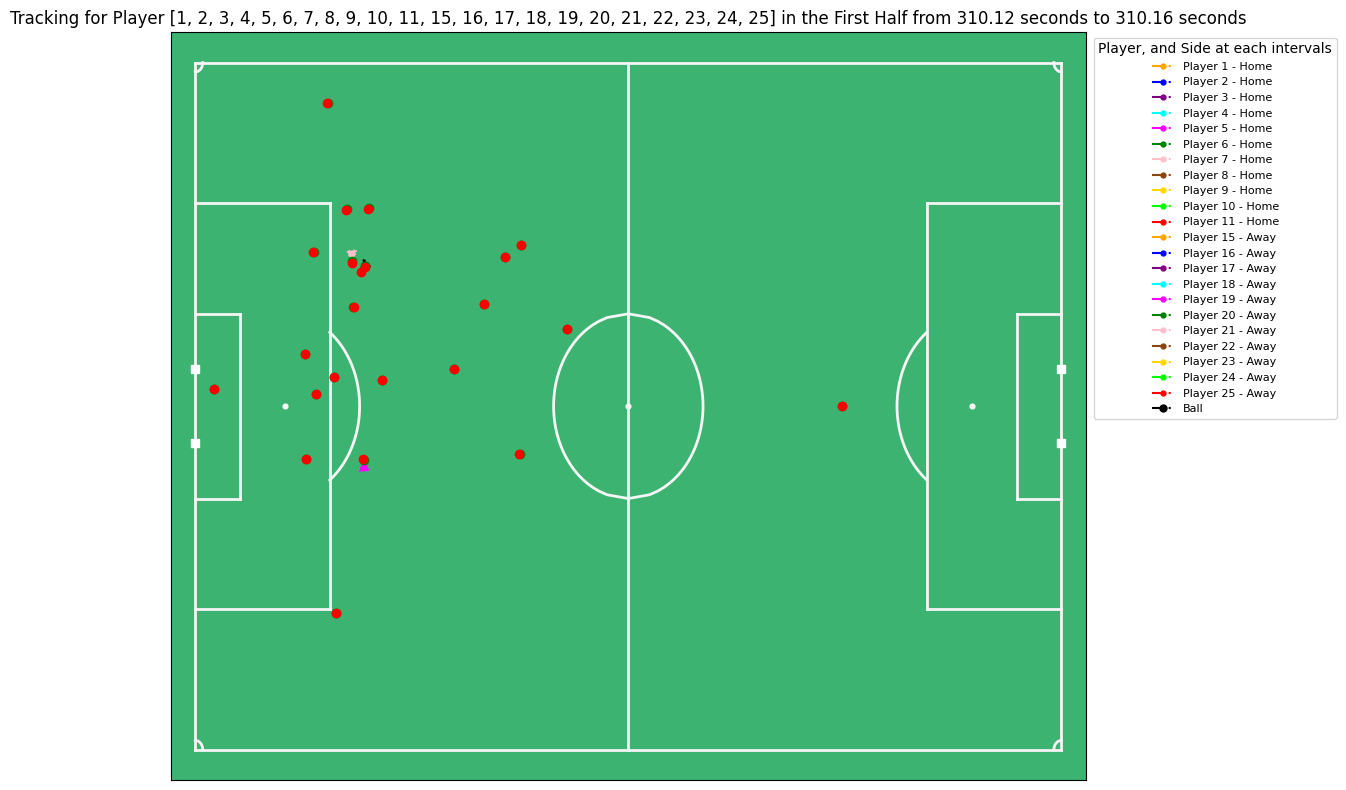

In [8]:
sides = ["Home"] * 11 + ["Away"] * 11
players = list(range(1, 12)) + list(range(15, 26))
game_2_pre.player_visualization(game_1_data.loc[7753:7754], players=players, sides=sides, plot_ball=True)
# game_2_pre.player_visualization(game_2_data.iloc[2:3], players=[1,2,3,4,5,6,7,8,9,10,11], sides=["Home"]*11, plot_ball=False)

In [9]:
# player_tracking(period_1_data)
# player_tracking(period_1_data_home, [2])
# player_tracking(period_1_data_home, [5])
# player_tracking(period_1_data_home, [8])

# Adding extra features to dataset

In [10]:
def calculate_velocity_acceleration_direction(dataset: pd.DataFrame, normalize: bool = True) -> pd.DataFrame:
    """
    Calculates the velocity, acceleration and direction of players and ball in a given dataset.

    Parameters:
        dataset (pandas.DataFrame): The input dataset containing player and ball positions over time.
        normalize (bool): Whether to normalize the calculated values.

    Returns:
        pandas.DataFrame: The original dataset with additional columns for velocity, acceleration and direction.
    """
    temp_data = dataset.copy()
    start_idx = temp_data.columns.get_loc("Time [s]")
    player_columns = temp_data.columns[start_idx + 1:]
    
    # Store all velocities/accelerations for global scaling
    all_velocities = []
    all_accelerations = []
    player_vel_mapping = {}
    player_acc_mapping = {}
    player_sin_mapping = {}
    player_cos_mapping = {}
    
    # First calculate all values
    for i in range(0, player_columns.shape[0] - 1, 2):
        ply_x, ply_y = player_columns[i], player_columns[i + 1]
        
        x_diff = temp_data[ply_x].diff()
        y_diff = temp_data[ply_y].diff()
        time_diff = temp_data["Frame"].diff()
        
        distance = np.sqrt(x_diff ** 2 + y_diff ** 2)
        velocity = distance / time_diff
        acceleration = velocity.diff() / time_diff
        
        # Calculate direction
        vel_x = x_diff / time_diff
        vel_y = y_diff / time_diff
        direction_rad = np.arctan2(vel_y, vel_x)
        
        direction_sine = np.sin(direction_rad)
        direction_cosine = np.cos(direction_rad)
        
        # Store values for later scaling and ordering
        if "Ball" in ply_x:
            entity = "Ball"
                            
            player_vel_mapping[entity] = velocity
            player_acc_mapping[entity] = acceleration
            player_sin_mapping[entity] = direction_sine
            player_cos_mapping[entity] = direction_cosine
            
            all_velocities.extend(velocity.dropna().tolist())
            all_accelerations.extend(acceleration.dropna().tolist())
    
    # Apply global scaling if requested
    if normalize:
        scaler_vel = MinMaxScaler(feature_range=(-1, 1))
        scaler_acc = MinMaxScaler(feature_range=(-1, 1))
        
        # Fit the scalers on all values
        scaler_vel.fit(np.array(all_velocities).reshape(-1, 1))
        scaler_acc.fit(np.array(all_accelerations).reshape(-1, 1))
        
        # Transform the values
        for entity in player_vel_mapping:
            player_vel_mapping[entity] = scaler_vel.transform(player_vel_mapping[entity].values.reshape(-1, 1)).flatten()
            player_acc_mapping[entity] = scaler_acc.transform(player_acc_mapping[entity].values.reshape(-1, 1)).flatten()
    
    # Add columns to dataframe in the desired order: velocity, acceleration, direction
    for entity in player_vel_mapping.keys():  # Sort to ensure consistent order
        temp_data[f"{entity}_velocity"] = player_vel_mapping[entity]
        temp_data[f"{entity}_acceleration"] = player_acc_mapping[entity]
        temp_data[f"{entity}_direction_sin"] = player_sin_mapping[entity]
        temp_data[f"{entity}_direction_cos"] = player_cos_mapping[entity]
    
    return temp_data

In [11]:
vel_acc_game_1_data = calculate_velocity_acceleration_direction(game_1_data)
vel_acc_game_2_data = calculate_velocity_acceleration_direction(game_2_data)
vel_acc_game_3_data = calculate_velocity_acceleration_direction(game_3_data)

In [12]:
vel_acc_game_3_data

,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,...,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y,Ball_velocity,Ball_acceleration,Ball_direction_sin,Ball_direction_cos
1,1,0.04,0.84722,0.52855,0.65268,0.24792,0.66525,0.46562,0.68103,0.59083,...,0.47050,0.73219,0.48864,0.36357,0.50125,0.48725,NaN,NaN,NaN,NaN
2,2,0.08,0.84722,0.52855,0.65231,0.24513,0.66482,0.46548,0.68095,0.59054,...,0.47040,0.73204,0.48834,0.36362,0.50125,0.48725,-1.0,NaN,0.0,1.0
3,3,0.12,0.84722,0.52855,0.65197,0.24387,0.66467,0.46537,0.68078,0.59035,...,0.47075,0.73229,0.48814,0.36372,0.50125,0.48725,-1.0,0.006941,0.0,1.0
4,4,0.16,0.84722,0.52855,0.65166,0.24288,0.66460,0.46488,0.68063,0.58987,...,0.47118,0.73266,0.48793,0.36278,0.50125,0.48725,-1.0,0.006941,0.0,1.0
5,5,0.20,0.84722,0.52855,0.65141,0.24251,0.66452,0.46469,0.68052,0.58934,...,0.47163,0.73287,0.48784,0.36240,0.50125,0.48725,-1.0,0.006941,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,143757,5750.28,0.11993,0.51783,0.47808,0.45408,0.49691,0.77311,0.46373,0.62102,...,0.46978,0.62349,0.80792,0.27106,0.89207,0.50485,-1.0,0.006941,0.0,1.0
143758,143758,5750.32,0.11993,0.51783,0.47786,0.45521,0.49701,0.77429,0.46381,0.62046,...,0.46970,0.62403,0.80712,0.27184,0.89207,0.50485,-1.0,0.006941,0.0,1.0
143759,143759,5750.36,0.11993,0.51783,0.47743,0.45709,0.49686,0.77555,0.46358,0.62117,...,0.46929,0.62479,0.80582,0.27242,0.89207,0.50485,-1.0,0.006941,0.0,1.0
143760,143760,5750.40,0.11993,0.51783,0.47669,0.45947,0.49676,0.77638,0.46306,0.62339,...,0.46866,0.62611,0.80444,0.27260,0.89207,0.50485,-1.0,0.006941,0.0,1.0


In [13]:
game_1_ply_tra = vel_acc_game_1_data.iloc[:, 3:]
game_2_ply_tra = vel_acc_game_2_data.iloc[:, 3:]
game_3_ply_tra = vel_acc_game_3_data.iloc[:, 2:] # This is different, no period (1 or 2)

In [14]:
game_2_ply_tra

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y,Ball_velocity,Ball_acceleration,Ball_direction_sin,Ball_direction_cos
1,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376,NaN,NaN,<NA>,<NA>
2,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376,-1.0,NaN,0.0,1.0
3,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376,-1.0,-0.002262,0.0,1.0
4,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376,-1.0,-0.002262,0.0,1.0
5,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376,-1.0,-0.002262,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891,-1.0,-0.002262,0.0,1.0
141153,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891,-1.0,-0.002262,0.0,1.0
141154,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891,-1.0,-0.002262,0.0,1.0
141155,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891,-1.0,-0.002262,0.0,1.0


In [15]:
# game_1_player_data = get_frame_data(game_1_ply_tra, columns=game_1_ply_tra.columns[0:46:2], feature="direction").fillna(0)
# game_2_player_data = get_frame_data(game_2_ply_tra, columns=game_2_ply_tra.columns[0:46:2], feature="direction").fillna(0)
# game_3_player_data = get_frame_data(game_3_ply_tra, columns=game_3_ply_tra.columns[0:46:2], feature="direction").fillna(0)

In [16]:
game_1_player_data = game_1_ply_tra.fillna(0).copy()
game_2_player_data = game_2_ply_tra.fillna(0).copy()
game_3_player_data = game_3_ply_tra.fillna(0).copy()

In [17]:
game_1_player_data = add_shot_prediction_features(game_1_player_data)
game_2_player_data = add_shot_prediction_features(game_2_player_data)
game_3_player_data = add_shot_prediction_features(game_3_player_data)

In [18]:
game_1_player_data["Ball_nearest_goal_distance"].values[2342:2390]

array([0.0468751 , 0.0468815 , 0.04689094, 0.04690342, 0.04691893,
       0.04693748, 0.04695905, 0.04698364, 0.04701125, 0.04704187,
       0.0470755 , 0.04711213, 0.04715176, 0.04719437, 0.04723996,
       0.04728851, 0.04734003, 0.0473945 , 0.04745191, 0.04751225,
       0.04757551, 0.04764167, 0.04771073, 0.04778267, 0.04785748,
       0.04793515, 0.04801566, 0.048099  , 0.04818515, 0.04827409,
       0.04836582, 0.04846032, 0.04855757, 0.04865755, 0.04876025,
       0.04886565, 0.04897373, 0.04908448, 0.04919787, 0.0493139 ,
       0.04943253, 0.04955376, 0.04967755, 0.0498039 , 0.04993279,
       0.05006419, 0.05019808, 0.05033445])

In [19]:
game_1_player_data["Ball_shot_probability"].values[2342:2390]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [20]:
game_1_player_data["Ball_direction_sin"].values[2342:2390]

<FloatingArray>
[-0.09749119837167886, -0.09749119837141632, -0.09749119837170758,
 -0.09749119837141632, -0.09749119837170758, -0.09749119837167886,
 -0.09749119837141632, -0.09749119837170758, -0.09749119837141632,
 -0.09749119837167886, -0.09749119837170758, -0.09749119837141632,
 -0.09749119837170758, -0.09749119837141632, -0.09749119837167886,
 -0.09749119837170758, -0.09749119837141632, -0.09749119837170758,
 -0.09749119837138759, -0.09749119837170758, -0.09749119837170758,
 -0.09749119837141632, -0.09749119837170758, -0.09749119837138759,
 -0.09749119837170758, -0.09749119837170758, -0.09749119837141632,
 -0.09749119837167886, -0.09749119837141632, -0.09749119837170758,
 -0.09749119837170758, -0.09749119837141632, -0.09749119837167886,
 -0.09749119837141632, -0.09749119837170758, -0.09749119837170758,
 -0.09749119837138759, -0.09749119837170758, -0.09749119837170758,
 -0.09749119837141632, -0.09749119837170758, -0.09749119837138759,
 -0.09749119837170758, -0.09749119837170758, -

In [19]:
game_1_data.loc[2250:2300]

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
2250,1.0,2250.0,90.00,0.26874,0.48488,0.87781,0.57140,0.89788,0.52524,0.91790,...,0.93573,0.48801,0.90898,0.49238,0.76992,0.55052,0.85693,0.20230,0.89814,0.13259
2251,1.0,2251.0,90.04,0.26874,0.48488,0.87842,0.57148,0.89834,0.52468,0.91798,...,0.93536,0.48820,0.90911,0.49169,0.77026,0.55008,0.85573,0.20181,0.89762,0.13287
2252,1.0,2252.0,90.08,0.26874,0.48488,0.87913,0.57161,0.89890,0.52402,0.91807,...,0.93503,0.48831,0.90929,0.49098,0.77060,0.54965,0.85454,0.20127,0.89709,0.13317
2253,1.0,2253.0,90.12,0.26874,0.48488,0.87984,0.57171,0.89945,0.52338,0.91820,...,0.93473,0.48845,0.90946,0.49029,0.77093,0.54921,0.85336,0.20074,0.89652,0.13346
2254,1.0,2254.0,90.16,0.26874,0.48488,0.88057,0.57193,0.90012,0.52255,0.91831,...,0.93437,0.48870,0.90969,0.48952,0.77127,0.54877,0.85217,0.20024,0.89598,0.13370
2255,1.0,2255.0,90.20,0.26874,0.48488,0.88127,0.57220,0.90078,0.52173,0.91843,...,0.93404,0.48896,0.90990,0.48882,0.77161,0.54833,0.85100,0.19976,0.89546,0.13389
2256,1.0,2256.0,90.24,0.26874,0.48488,0.88198,0.57259,0.90152,0.52086,0.91856,...,0.93368,0.48929,0.91012,0.48814,0.77195,0.54789,0.84984,0.19931,0.89494,0.13410
2257,1.0,2257.0,90.28,0.26875,0.48488,0.88270,0.57289,0.90225,0.52000,0.91870,...,0.93334,0.48958,0.91034,0.48747,0.77228,0.54745,0.84871,0.19881,0.89443,0.13425
2258,1.0,2258.0,90.32,0.26876,0.48488,0.88344,0.57332,0.90297,0.51915,0.91883,...,0.93301,0.48990,0.91055,0.48682,0.77262,0.54701,0.84757,0.19834,0.89390,0.13450
2259,1.0,2259.0,90.36,0.26877,0.48488,0.88414,0.57380,0.90368,0.51831,0.91892,...,0.93271,0.49030,0.91076,0.48618,0.77296,0.54657,0.84642,0.19805,0.89340,0.13462


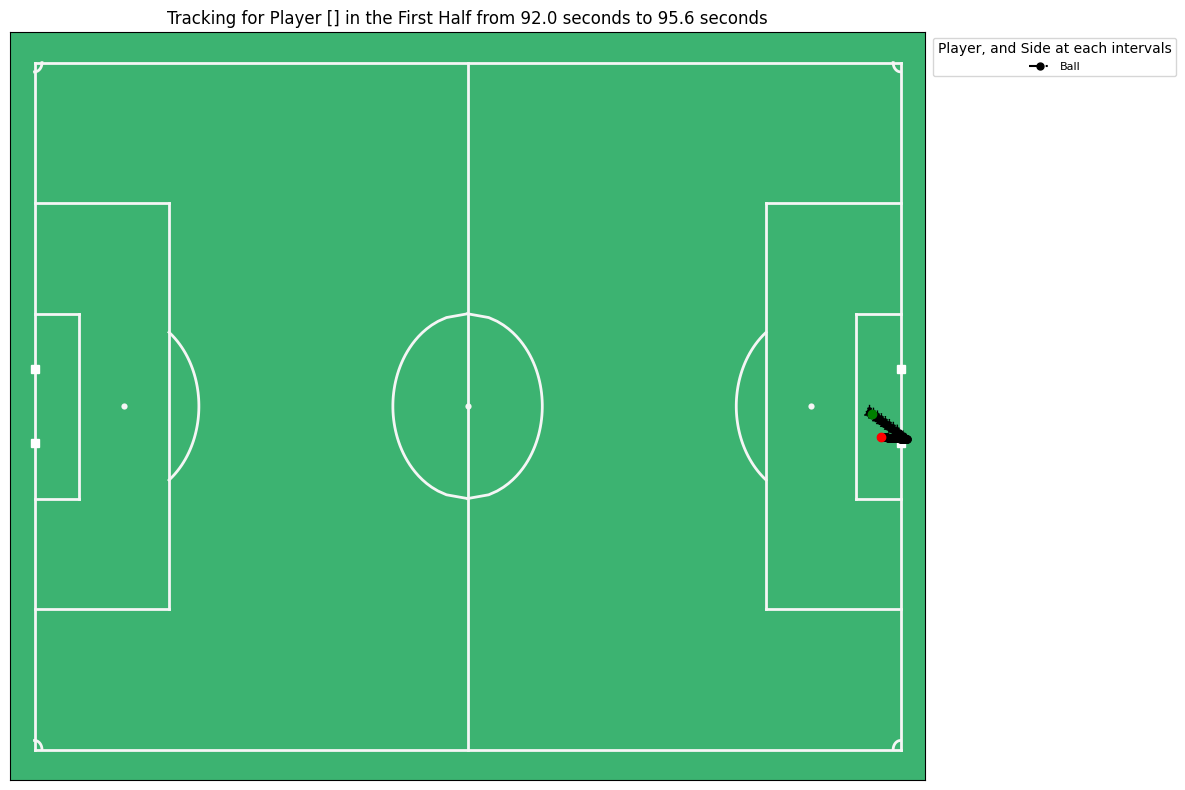

In [46]:
sides = ["Home"] * 11 + ["Away"] * 11
players = list(range(1, 12)) + list(range(15, 26))
game_2_pre.player_visualization(game_1_data.loc[2300:2390], players=[], sides=[], plot_ball=True)
# game_2_pre.player_visualization(game_2_data.iloc[2:3], players=[1,2,3,4,5,6,7,8,9,10,11], sides=["Home"]*11, plot_ball=False)

In [34]:
game_1_player_data[game_1_player_data["Ball_shot_probability"] > 0].iloc[90:140]

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y,Ball_velocity,Ball_acceleration,Ball_direction_sin,Ball_direction_cos,Ball_nearest_goal_distance,Ball_shot_probability
5895,0.12670,0.47880,0.47714,0.68510,0.45755,0.57023,0.43308,0.44189,0.50159,0.24212,...,0.43149,0.44977,0.808880,0.200440,-0.989822,-0.000306,0.861513,0.507736,0.355335,0.450004
5896,0.12693,0.47890,0.47848,0.68494,0.45811,0.56997,0.43423,0.44208,0.50287,0.24248,...,0.43273,0.44945,0.810400,0.202980,-0.990131,-0.000409,0.858089,0.513502,0.352376,0.456917
5897,0.12715,0.47901,0.47984,0.68483,0.45865,0.56970,0.43537,0.44229,0.50413,0.24278,...,0.43396,0.44921,0.811870,0.205540,-0.990158,-0.000268,0.867199,0.497962,0.349428,0.448685
5925,0.13070,0.48125,0.51512,0.68276,0.47027,0.56108,0.46379,0.44709,0.53181,0.25654,...,0.46356,0.44702,0.843700,0.284810,-0.956075,0.013956,0.848595,0.529043,0.265963,0.534341
5926,0.13073,0.48127,0.51629,0.68275,0.47060,0.56069,0.46473,0.44714,0.53249,0.25718,...,0.46442,0.44708,0.850670,0.296000,-0.956047,-0.000240,0.848807,0.528703,0.252815,0.549274
5927,0.13075,0.48127,0.51747,0.68274,0.47091,0.56035,0.46565,0.44714,0.53315,0.25783,...,0.46527,0.44714,0.857630,0.307190,-0.956064,-0.000263,0.849147,0.528156,0.239677,0.846742
5928,0.13078,0.48127,0.51863,0.68277,0.47122,0.56002,0.46657,0.44716,0.53376,0.25847,...,0.46609,0.44714,0.864600,0.318370,-0.956075,-0.000260,0.848595,0.529043,0.226545,0.871576
5929,0.13081,0.48127,0.51977,0.68280,0.47154,0.55974,0.46748,0.44720,0.53437,0.25912,...,0.46689,0.44720,0.871570,0.329560,-0.956047,-0.000240,0.848807,0.528703,0.213411,0.895981
5930,0.13082,0.48127,0.52091,0.68287,0.47185,0.55950,0.46835,0.44725,0.53495,0.25977,...,0.46768,0.44720,0.878540,0.340750,-0.956047,-0.000254,0.848807,0.528703,0.200283,0.921392
5931,0.13084,0.48127,0.52203,0.68298,0.47215,0.55927,0.46922,0.44713,0.53552,0.26042,...,0.46845,0.44721,0.885500,0.351930,-0.956093,-0.000277,0.848935,0.528497,0.187176,0.947315


# Classification

In [21]:
game_1_event = prepare_event_data("data/Sample_Game_1/Sample_Game_1_RawEventsData.csv", game_1_data)
game_2_event = prepare_event_data("data/Sample_Game_2/Sample_Game_2_RawEventsData.csv", game_2_data)
game_3_event = prepare_json_event_data("data/Sample_Game_3/Sample_Game_3_events.json", game_3_data)

In [22]:
game_1_event

,Type
3,PASS
4,PASS
5,PASS
6,PASS
7,PASS
...,...
143614,BALL LOST
143615,BALL LOST
143616,BALL LOST
143617,BALL LOST


In [23]:
game_2_event

,Type
146,PASS
147,PASS
148,PASS
149,PASS
150,PASS
...,...
141152,BALL OUT
141153,BALL OUT
141154,BALL OUT
141155,BALL OUT


In [24]:
game_3_event

,Type
384,PASS
385,PASS
386,PASS
387,PASS
388,PASS
...,...
143529,PASS
143530,PASS
143531,PASS
143532,PASS


In [25]:
common_indices = game_1_event.index.intersection(game_1_player_data.index)
X_1 = game_1_player_data.loc[common_indices]
y_1 = game_1_event.loc[common_indices]

assert X_1.shape[0] == y_1.shape[0]

In [26]:
common_indices = game_2_event.index.intersection(game_2_player_data.index)
X_2 = game_2_player_data.loc[common_indices]
y_2 = game_2_event.loc[common_indices]

assert X_2.shape[0] == y_2.shape[0]

In [27]:
common_indices = game_3_event.index.intersection(game_3_player_data.index)
X_3 = game_3_player_data.loc[common_indices]
y_3 = game_3_event.loc[common_indices]

assert X_3.shape[0] == y_3.shape[0]

In [28]:
X_2

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y,Ball_velocity,Ball_acceleration,Ball_direction_sin,Ball_direction_cos,Ball_nearest_goal_distance,Ball_shot_probability
146,0.92146,0.49193,0.66669,0.25888,0.68402,0.40418,0.65595,0.55007,0.65875,0.79306,...,0.56354,0.40130,0.42486,0.50205,-0.996737,-0.002274,-0.914535,0.404506,0.424865,0.0
147,0.92105,0.49184,0.66734,0.25738,0.68413,0.40344,0.65592,0.54961,0.65911,0.79202,...,0.56392,0.40070,0.42550,0.49495,-0.959088,0.016687,-0.995962,0.089777,0.425530,0.0
148,0.92065,0.49174,0.66796,0.25587,0.68424,0.40257,0.65590,0.54908,0.65947,0.79090,...,0.56431,0.40010,0.42595,0.48802,-0.960145,-0.002794,-0.997898,0.064799,0.426118,0.0
149,0.92021,0.49171,0.66856,0.25436,0.68433,0.40168,0.65585,0.54861,0.65982,0.78977,...,0.56468,0.39944,0.42640,0.48108,-0.960088,-0.002233,-0.997904,0.064706,0.426820,0.0
150,0.91975,0.49171,0.66915,0.25276,0.68442,0.40080,0.65580,0.54814,0.66015,0.78859,...,0.56507,0.39863,0.42685,0.47415,-0.960145,-0.002291,-0.997898,0.064799,0.427632,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.36760,0.12496,0.40958,-0.03891,-1.000000,-0.002262,0.0,1.0,0.676890,0.0
141153,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.36760,0.12496,0.40958,-0.03891,-1.000000,-0.002262,0.0,1.0,0.676890,0.0
141154,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.36760,0.12496,0.40958,-0.03891,-1.000000,-0.002262,0.0,1.0,0.676890,0.0
141155,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.36760,0.12496,0.40958,-0.03891,-1.000000,-0.002262,0.0,1.0,0.676890,0.0


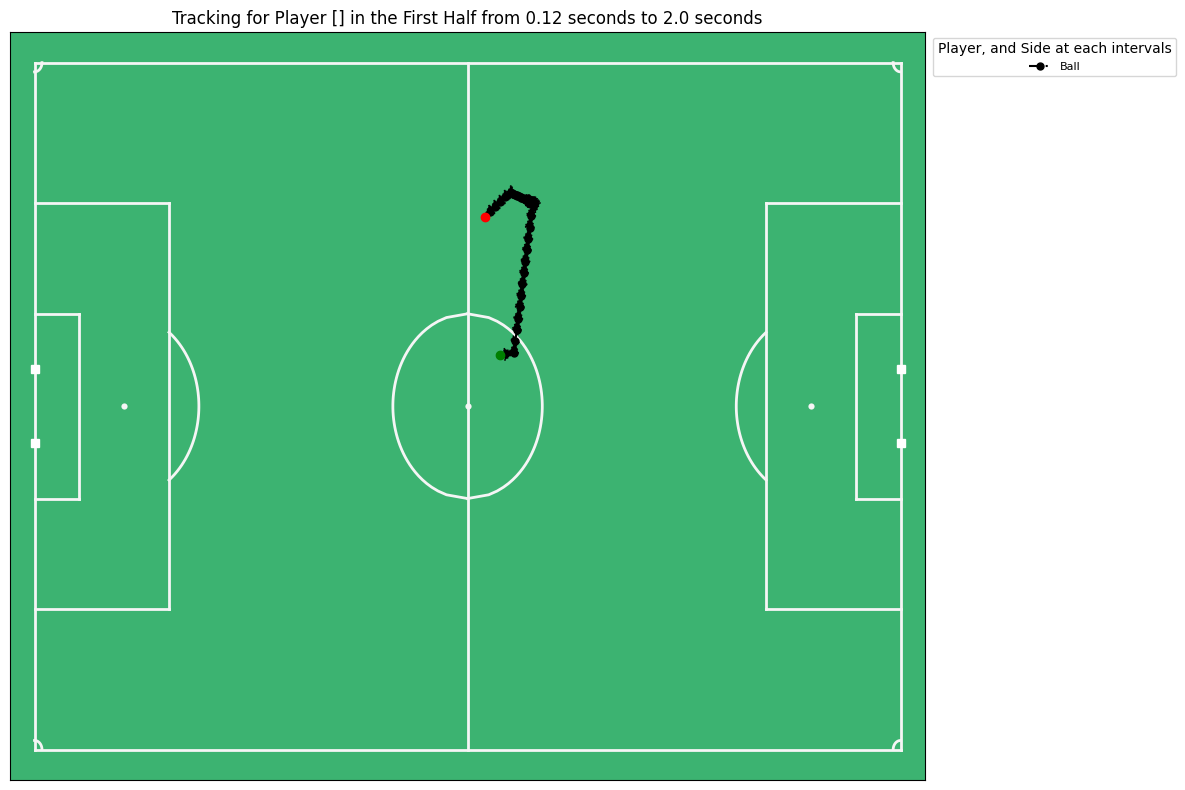

In [29]:
sides = ["Home"] * 11 + ["Away"] * 11
players = list(range(1, 12)) + list(range(15, 26))
game_2_pre.player_visualization(game_1_data.loc[3:50], players=[], sides=[], plot_ball=True)
# game_2_pre.player_visualization(game_2_data.iloc[2:3], players=[1,2,3,4,5,6,7,8,9,10,11], sides=["Home"]*11, plot_ball=False)

In [45]:
al_x = 1 - X_2.loc[27345:27360, "Ball-x"]
al_y = 0.5 - X_2.loc[27345:27360, "Ball-y"]

top = X_2.loc[27345:27360, "Ball-x"] * al_x + X_2.loc[27345:27360, "Ball-y"] * al_y

In [46]:
X_2.loc[27345:27360, ["Ball-x", "Ball-y"]].round(5)

,Ball-x,Ball-y
27345,0.08656,0.58572
27346,0.08142,0.59085
27347,0.07513,0.59079
27348,0.06899,0.59073
27349,0.06254,0.59067
27350,0.05624,0.59061
27351,0.04995,0.59056
27352,0.04366,0.59050
27353,0.03736,0.59044
27354,0.03107,0.59038


In [47]:
X_2.loc[27345:27360, "Ball_direction_sin"] * X_2.loc[27345:27360, "Ball_direction_cos"]

27345   -0.271488
27346   -0.499999
27347    0.009538
27348    0.009771
27349    0.009302
27350    0.009523
27351    0.007949
27352    0.009538
27353    0.009523
27354    0.009538
27355    0.009771
27356    0.009302
27357    0.007949
27358    0.009523
27359    0.009538
27360    0.009523
dtype: Float64

In [48]:
game_2_event.loc[27345:27360]

,Type
27345,SHOT
27346,SHOT
27347,SHOT
27348,SHOT
27349,SHOT
27350,SHOT
27351,SHOT
27352,SHOT
27353,SHOT
27354,SHOT


### Adding which team has the ball using distance metrics

In [30]:
def add_team_with_ball(event_df, full_data):
    events_to_leave_out=["FAULT RECEIVED", "SET PIECE", "CARD", "CHALLENGE"]
    game_event_data = pd.read_csv(event_df)    
    game_event_data = game_event_data[~(game_event_data["Type"].isin(events_to_leave_out))]
    event_data = game_event_data.replace("RECOVERY", "BALL LOST")    

    ball_out_idx = full_data.index[
        (full_data["Ball-x"] < 0) | (full_data["Ball-x"] > 1) |
        (full_data["Ball-y"] < 0) | (full_data["Ball-y"] > 1)
    ]

    ball_out_df = pd.DataFrame({
        "Team": "BALL OUT"
    }, index=ball_out_idx)
    
    event_data = event_data[~(event_data["Type"] == "BALL OUT")]
    start_frames = event_data["Start Frame"].iloc[1:].to_numpy()
    end_frames = event_data["End Frame"].iloc[1:].to_numpy()
    event_types = event_data["Team"].iloc[1:].to_numpy()

    # Validation
    assert start_frames.shape == end_frames.shape == event_types.shape

    # Ensure end frames don't exceed data bounds
    end = full_data.index[-1]
    end_frames = np.minimum(end_frames, end)

    # Create frame ranges and unique indices
    frame_ranges = [np.arange(min(i, j), max(i, j) + 1)
                    for i, j in zip(start_frames, end_frames)]
    unique_indices = np.unique(np.concatenate(frame_ranges))

    # Create and populate event DataFrame
    event_df = pd.DataFrame(index=unique_indices, columns=["Team"])
    for s, e, e_t in zip(start_frames, end_frames, event_types):
        event_df.loc[s:e, "Team"] = e_t
        
    combined_event_df = ball_out_df.combine_first(event_df)
    
    return replace_c_with_previous(combined_event_df.dropna())

In [31]:
def add_team_with_ball_json(event_df, full_data):
    import json

    with open(event_df, "r") as f:
        event = json.load(f)
        
    type_ = np.array([])
    team_ = np.array([])
    start_frame = np.array([])
    end_frame = np.array([])
    
    for i in event["data"]:
        t = i["type"]["name"]
        te = i["team"]["name"]
        sf = i["start"]["frame"]
        ef = i["end"]["frame"]
    
        if t != "CARRY" and t != "BALL OUT":
            type_ = np.append(type_, t)
            team_ = np.append(team_, te)
            start_frame = np.append(start_frame, sf)
            end_frame = np.append(end_frame, ef)
    
    
    game_event_data = pd.DataFrame({"Type": type_, "Team": team_, "Start Frame": start_frame.astype(np.int64), "End Frame": end_frame.astype(np.int64)})
    events_to_leave_out=["FAULT RECEIVED", "SET PIECE", "CARD", "CHALLENGE"]

    game_event_data = game_event_data[~(game_event_data["Type"].isin(events_to_leave_out))]


    event_data = game_event_data.replace("RECOVERY", "BALL LOST")
    ball_out_idx = full_data.index[
        (full_data["Ball-x"] < 0) | (full_data["Ball-x"] > 1) |
        (full_data["Ball-y"] < 0) | (full_data["Ball-y"] > 1)
    ]

    ball_out_df = pd.DataFrame({
        "Team": "BALL OUT"
    }, index=ball_out_idx)
    
    event_data = event_data[~(event_data["Type"] == "BALL OUT")]
    start_frames = event_data["Start Frame"].iloc[1:].to_numpy()
    end_frames = event_data["End Frame"].iloc[1:].to_numpy()
    event_types = event_data["Team"].iloc[1:].to_numpy()

    # Validation
    assert start_frames.shape == end_frames.shape == event_types.shape

    # Ensure end frames don't exceed data bounds
    end = full_data.index[-1]
    end_frames = np.minimum(end_frames, end)

    # Create frame ranges and unique indices
    frame_ranges = [np.arange(min(i, j), max(i, j) + 1)
                    for i, j in zip(start_frames, end_frames)]
    unique_indices = np.unique(np.concatenate(frame_ranges))

    # Create and populate event DataFrame
    event_df = pd.DataFrame(index=unique_indices, columns=["Team"])
    for s, e, e_t in zip(start_frames, end_frames, event_types):
        event_df.loc[s:e, "Team"] = e_t
        
    combined_event_df = ball_out_df.combine_first(event_df)
    
    return replace_c_with_previous(combined_event_df.dropna())

In [32]:
def replace_c_with_previous(df):
    prev_value = None
    new_types = []

    for val in df['Team']:
        if val != 'BALL OUT':
            prev_value = val
            new_types.append(val)
        else:
            new_types.append(prev_value)

    df['Team'] = new_types
    return df

In [33]:
def add_ball_with(closest_to_ball: pd.DataFrame):
    # Assume the column of interest is the first column.
    col = closest_to_ball.iloc[:, 0].str.lower()
    
    # Use numpy.where to vectorize the assignment.
    team = np.where(col.str.startswith("home"), 0, 
                    np.where(col.str.startswith("away"), 1, np.nan))
    
    return team

def add_ball_with_json(closest_to_ball: pd.DataFrame):
    # Assume the column of interest is the first column.
    col = closest_to_ball.iloc[:, 0].str.lower()
    
    # Use numpy.where to vectorize the assignment.
    team = np.where(col.str.startswith("team a"), 0, 
                    np.where(col.str.startswith("team b"), 1, np.nan))
    
    return team

In [34]:
X_1["Team"] = add_ball_with(add_team_with_ball("data/Sample_Game_1/Sample_Game_1_RawEventsData.csv", game_1_data))
X_2["Team"] = add_ball_with(add_team_with_ball("data/Sample_Game_2/Sample_Game_2_RawEventsData.csv", game_2_data))
X_3["Team"] = add_ball_with_json(add_team_with_ball_json("data/Sample_Game_3/Sample_Game_3_events.json", game_3_data))

In [35]:
X_1["Ball-y"]

3         0.42556
4         0.42231
5         0.40570
6         0.38909
7         0.37248
           ...   
143614    0.62709
143615    0.62314
143616    0.61919
143617    0.61523
143618    0.61128
Name: Ball-y, Length: 57785, dtype: float64

In [36]:
X_1

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,Away-Player24-y,Ball-x,Ball-y,Ball_velocity,Ball_acceleration,Ball_direction_sin,Ball_direction_cos,Ball_nearest_goal_distance,Ball_shot_probability,Team
3,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,0.35529,0.32137,0.21262,...,0.27383,0.53716,0.42556,-0.850216,-0.002128,0.422922,0.906166,0.468788,0.0,1.0
4,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,0.35554,0.32142,0.21241,...,0.27473,0.55346,0.42231,-0.944585,-0.047479,-0.195538,0.980696,0.453248,0.0,1.0
5,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,0.35528,0.32136,0.21159,...,0.27543,0.55512,0.40570,-0.944346,-0.000134,-0.995043,0.099444,0.454764,0.0,1.0
6,0.00140,0.48238,0.32581,0.65159,0.33637,0.48966,0.30978,0.35479,0.32159,0.21051,...,0.27673,0.55677,0.38909,-0.944349,-0.000256,-0.995102,0.098851,0.456896,0.0,1.0
7,0.00140,0.48238,0.32570,0.65037,0.33624,0.48919,0.31015,0.35439,0.32198,0.20921,...,0.27751,0.55842,0.37248,-0.944349,-0.000254,-0.995102,0.098851,0.459624,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143614,0.87621,0.48890,0.25147,0.54818,0.47196,0.44820,0.50936,0.57808,0.11104,0.67714,...,0.56158,0.08382,0.62709,-0.983072,-0.000265,-0.777978,-0.628291,0.152242,1.0,0.0
143615,0.87601,0.48911,0.25096,0.54821,0.47157,0.44844,0.50890,0.57796,0.11004,0.67616,...,0.56196,0.08062,0.62314,-0.983051,-0.000244,-0.777016,-0.629481,0.147184,1.0,0.0
143616,0.87583,0.48933,0.25045,0.54823,0.47120,0.44872,0.50844,0.57788,0.10914,0.67526,...,0.56233,0.07743,0.61919,-0.983072,-0.000265,-0.777978,-0.628291,0.142133,1.0,0.0
143617,0.87564,0.48954,0.24996,0.54830,0.47084,0.44899,0.50799,0.57768,0.10829,0.67433,...,0.56268,0.07423,0.61523,-0.983025,-0.000231,-0.777793,-0.62852,0.137069,1.0,1.0


In [37]:
# away_cols = X_1.columns.str.startswith("Away")
# X_1.loc[:, away_cols] = X_1.loc[:, away_cols] * -1

# away_cols = X_2.columns.str.startswith("Away")
# X_2.loc[:, away_cols] = X_2.loc[:, away_cols] * -1

# away_cols = X_3.columns.str.startswith("Away")
# X_3.loc[:, away_cols] = X_3.loc[:, away_cols] * -1

In [38]:
np.unique(y_1, return_counts=True)

(array(['BALL LOST', 'BALL OUT', 'PASS', 'SHOT'], dtype=object),
 array([10071, 19023, 28145,   546]))

In [39]:
np.unique(y_2, return_counts=True)

(array(['BALL LOST', 'BALL OUT', 'PASS', 'SHOT'], dtype=object),
 array([ 7742, 15537, 32338,   485]))

In [40]:
np.unique(y_3, return_counts=True)

(array(['BALL LOST', 'BALL OUT', 'PASS', 'SHOT'], dtype=object),
 array([11107, 19620, 42896,   391]))

In [41]:
scaler = MinMaxScaler()
X_1_scaled = X_1.values#pd.concat([X_1.iloc[:, :46], X_1.iloc[:, -3:]], axis=1).values#scaler.fit_transform(X_1)
X_2_scaled = X_2.values#pd.concat([X_2.iloc[:, :46], X_2.iloc[:, -3:]], axis=1).values#scaler.transform(X_2)
X_3_scaled = X_3.values#pd.concat([X_3.iloc[:, :46], X_3.iloc[:, -3:]], axis=1).values#scaler.transform(X_3)

# X_1_scaled = minmax_scale(X_1, axis=0)
# X_2_scaled = minmax_scale(X_2, axis=0)
# X_3_scaled = minmax_scale(X_3, axis=0)

# label_encoder = LabelEncoder()
# y_1_encoded = label_encoder.fit_transform(y_1)
# y_2_encoded = label_encoder.transform(y_2)
# y_3_encoded = label_encoder.transform(y_3)

In [42]:
print(X_1_scaled.shape)
print(X_2_scaled.shape)
print(X_3_scaled.shape)

(57785, 53)
(56102, 53)
(74014, 53)


In [45]:
X = np.concatenate([X_3_scaled, X_2_scaled])
y = np.concatenate((y_3, y_2)).ravel()

assert X.shape[0] == y.shape[0]

In [ ]:
clf = xgb.XGBClassifier(tree_method="hist", early_stopping_rounds=2)
# Fit the model, test sets are used for early stopping.
clf.fit(X_train, y_train, eval_set=[(X_test, y_test)])
# Save model into JSON format.
clf.save_model("clf.json")

In [49]:
label_encoder = LabelEncoder()
y_1_encoded = label_encoder.fit_transform(y_1)
y_2_encoded = label_encoder.transform(y_2)
y_3_encoded = label_encoder.transform(y_3)

X_encoded = np.concatenate([X_3_scaled, X_2_scaled])
y_encoded = np.concatenate((y_3_encoded, y_2_encoded)).ravel()

C:\Users\racr\Desktop\Million's workspace\Thesis-main\Thesis-main\Real-Time LLM Football Commentary\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\racr\Desktop\Million's workspace\Thesis-main\Thesis-main\Real-Time LLM Football Commentary\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
C:\Users\racr\Desktop\Million's workspace\Thesis-main\Thesis-main\Real-Time LLM Football Commentary\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y t

In [50]:
# %load_ext cuml.accel

In [57]:
models = {
      # "AdaBoost classifier": AdaBoostClassifier(), 
      # "Logistic regression": LogisticRegression(solver="saga"),
      # "Random forest classifier": RandomForestClassifier(n_jobs=-1),
      "XGBoost": XGBClassifier(n_estimators=4, max_depth=6, learning_rate=0.01)
        
    }

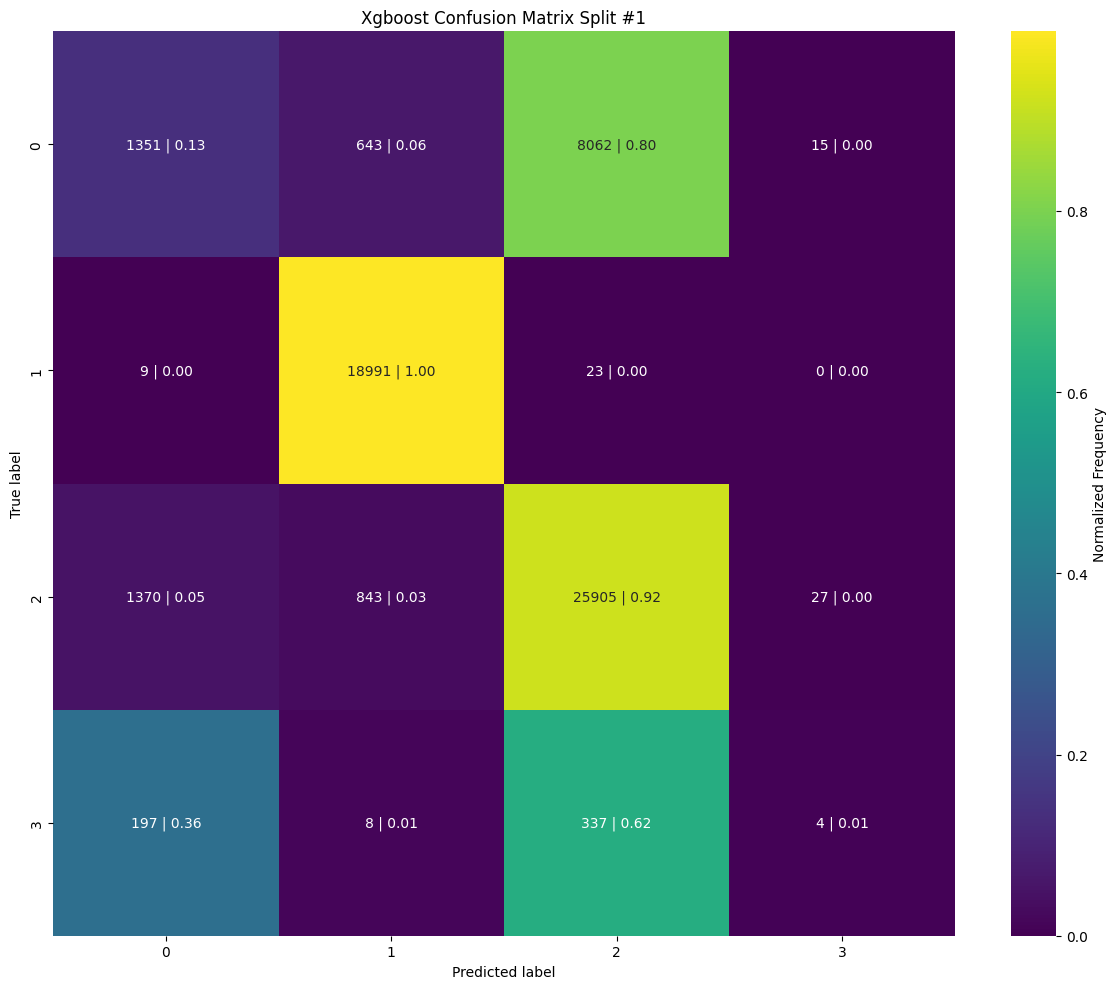

XGBoost training accuracy: 88.89%
XGBoost testing accuracy: 80.04%

XGBoost testing precision: 75.40%
XGBoost testing recall: 80.04%
XGBoost testing f1: 75.68%




In [58]:
for name, model in models.items():
    if name == "XGBoost":
        model.fit(X_encoded, y_encoded)
        y_train_pred = model.predict(X_encoded)
        y_pred = model.predict(X_1_scaled)    
        labels = np.unique(y_encoded)
        
        _ = plot_confusion_matrix(y_train=y_encoded, y_train_pred=y_train_pred, y_test=y_1_encoded, y_pred=y_pred, labels=labels, split=0, model_name=name)
    else:
        model.fit(X, y)
        y_train_pred = model.predict(X)
        y_pred = model.predict(X_1_scaled)    
        labels = np.unique(y)
        
        _ = plot_confusion_matrix(y_train=y, y_train_pred=y_train_pred, y_test=y_1, y_pred=y_pred, labels=labels, split=0, model_name=name)
    
    # print("\n")


Performing Grid Search for AdaBoost classifier...
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best parameters for AdaBoost classifier: {'learning_rate': 1.0, 'n_estimators': 200}


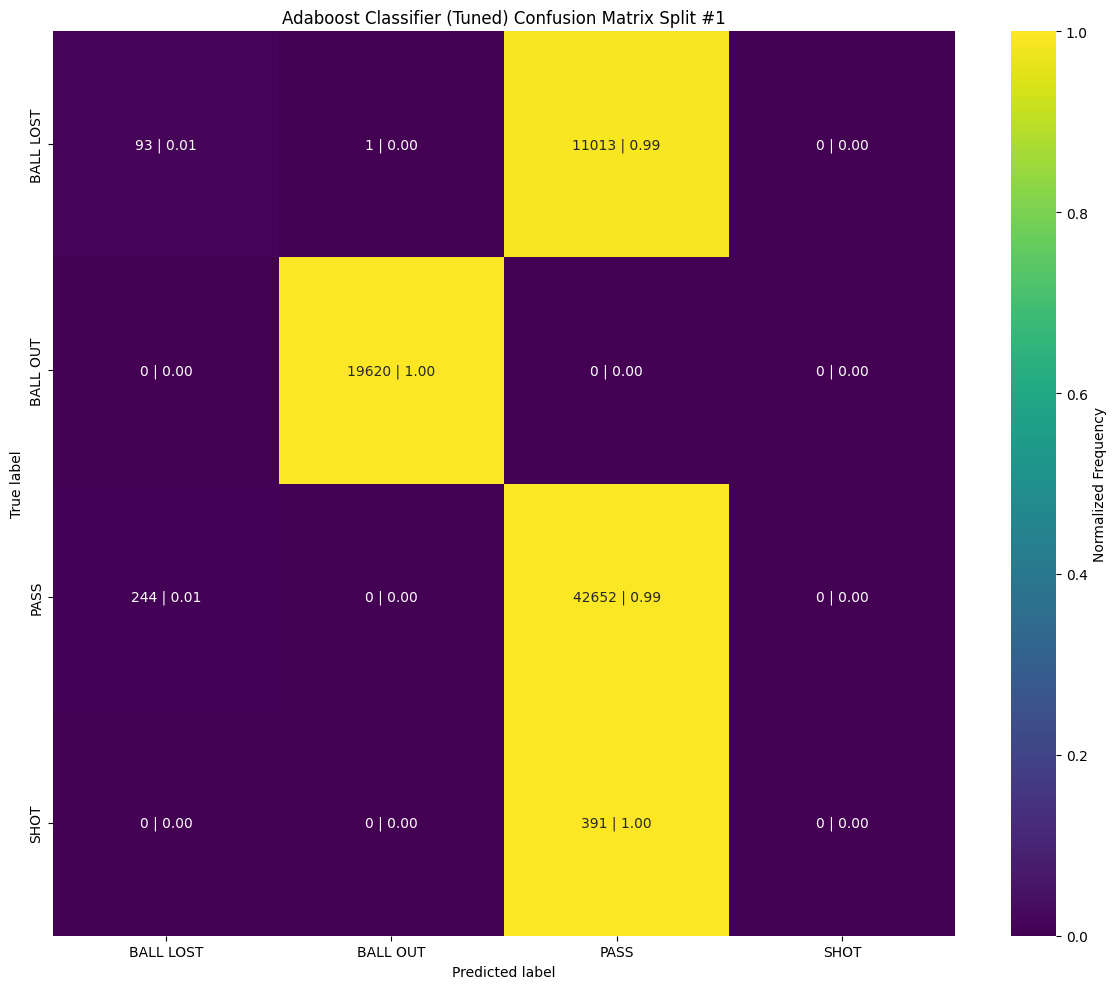

AdaBoost classifier (tuned) training accuracy: 83.20%
AdaBoost classifier (tuned) testing accuracy: 84.26%

AdaBoost classifier (tuned) testing precision: 76.38%
AdaBoost classifier (tuned) testing recall: 84.26%
AdaBoost classifier (tuned) testing f1: 77.75%



Performing Grid Search for Logistic regression...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters for Logistic regression: {'C': 0.01, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}


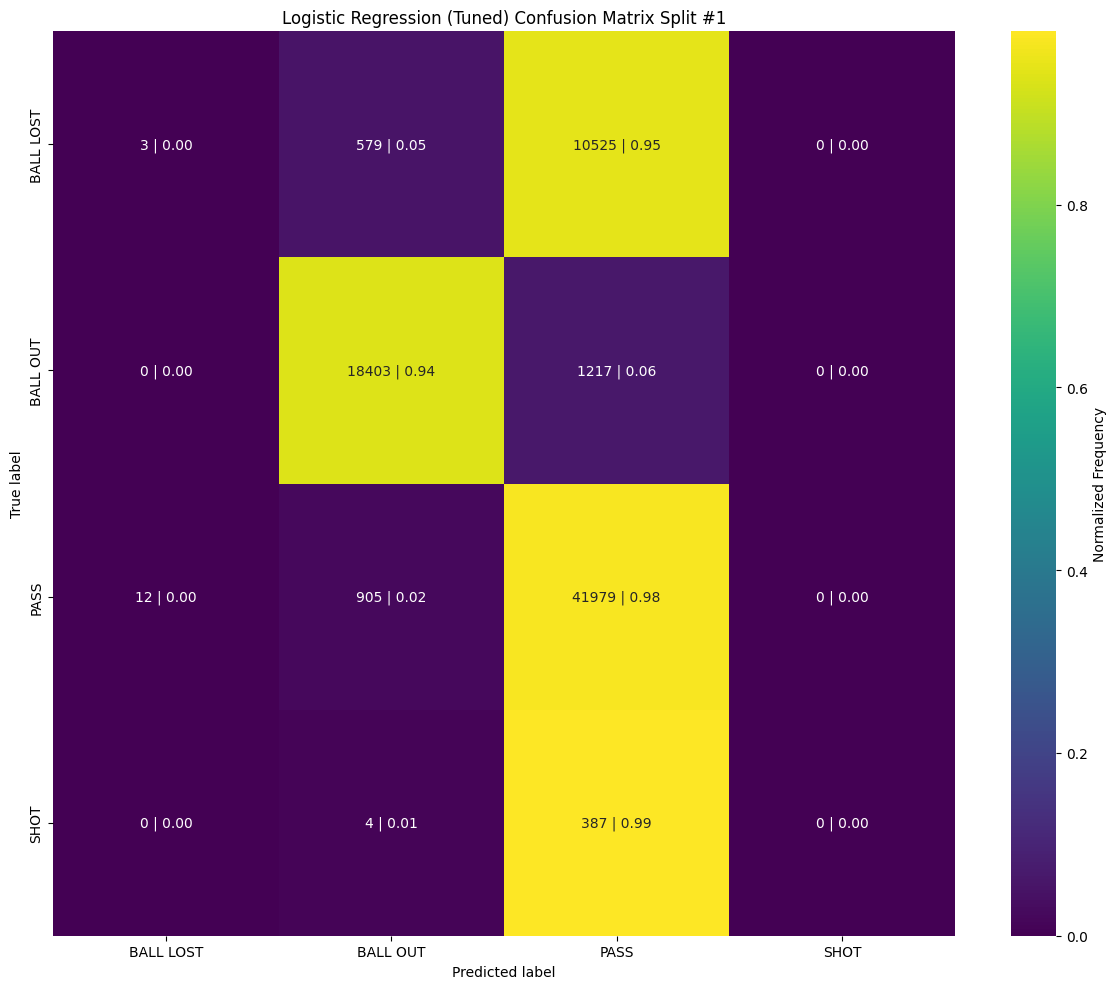

Logistic regression (tuned) training accuracy: 80.26%
Logistic regression (tuned) testing accuracy: 81.59%

Logistic regression (tuned) testing precision: 72.49%
Logistic regression (tuned) testing recall: 81.59%
Logistic regression (tuned) testing f1: 74.86%



Performing Grid Search for Random forest classifier...
Fitting 3 folds for each of 60 candidates, totalling 180 fits
Best parameters for Random forest classifier: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 50, 'n_jobs': -1}


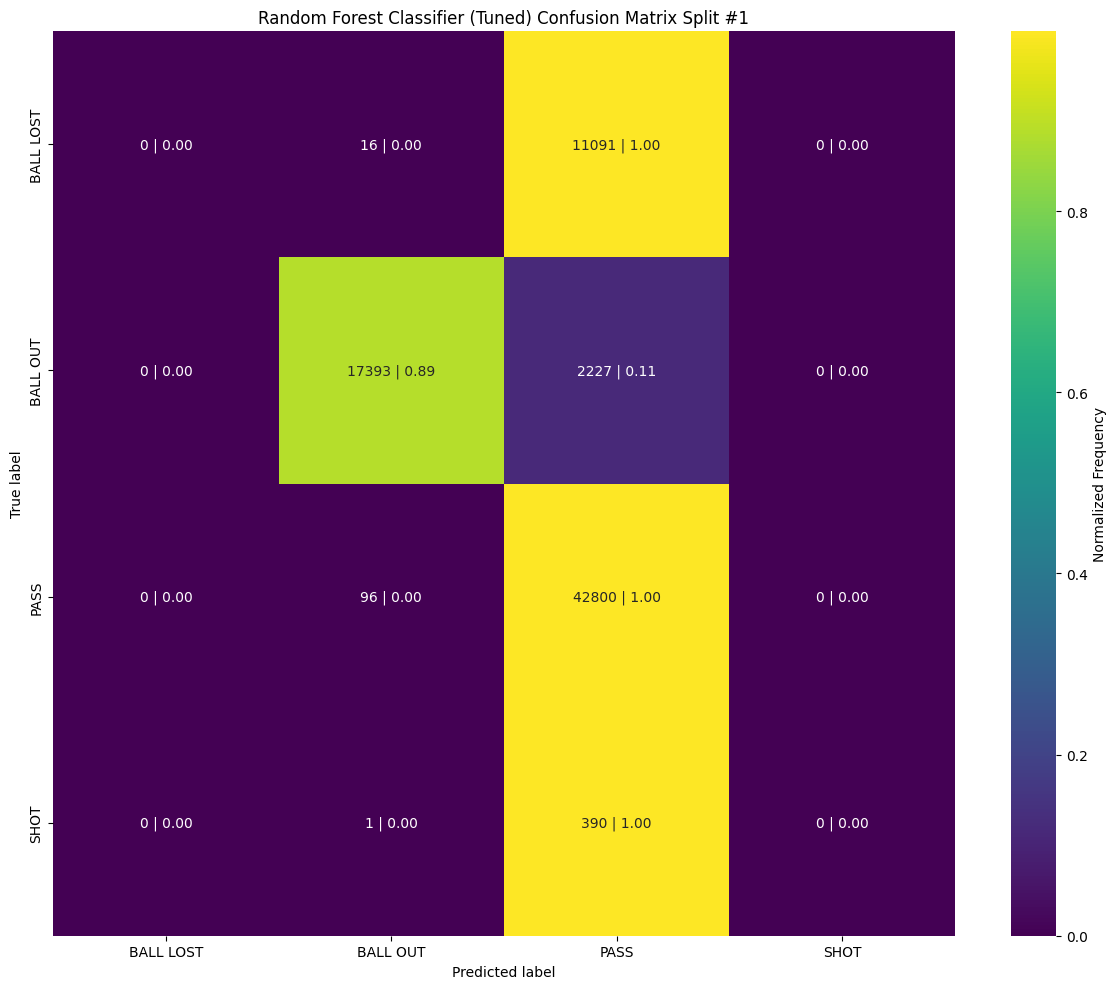

Random forest classifier (tuned) training accuracy: 82.42%
Random forest classifier (tuned) testing accuracy: 81.33%

Random forest classifier (tuned) testing precision: 70.23%
Random forest classifier (tuned) testing recall: 81.33%
Random forest classifier (tuned) testing f1: 74.75%




In [44]:
param_grids = {
    "AdaBoost classifier": {
        'n_estimators': [100, 150, 200, 250, 300],
        'learning_rate': [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
    },
    "Logistic regression": {
        'penalty': ['l1', 'l2'],
        'C': [0.0001, 0.001, 0.01, 0.1, 1],
        'solver': ['saga'],
        'max_iter': [500, 750, 1000, 1250]
    },
    "Random forest classifier": {
        'n_estimators': [20, 30, 40, 50, 60, 70],
        'max_depth': [4, 5, 6, 7, 8, 9],
        'min_samples_split': [3, 4, 5, 6, 7],
        "max_features": ["sqrt", "log2"],
        'n_jobs': [-1],  # Always use all cores
        "criterion": ["entropy", "gini"]
    }
}

# Dictionary to store best models
best_models = {}

for name, model in models.items():
    print(f"\nPerforming Grid Search for {name}...")

    grid_search = GridSearchCV(model, param_grids[name], cv=3, n_jobs=-1, verbose=4)
    grid_search.fit(X, y)
    
    best_model = grid_search.best_estimator_
    best_models[name] = best_model
    
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    
    # Predict and evaluate
    y_train_pred = best_model.predict(X)
    y_pred = best_model.predict(X_3_scaled)
    labels = np.unique(y)
    
    _ = plot_confusion_matrix(
        y_train=y,
        y_train_pred=y_train_pred,
        y_test=y_3,
        y_pred=y_pred,
        labels=labels,
        split=0,
        model_name=f"{name} (tuned)"
    )



Performing Grid Search for AdaBoost classifier...
Fitting 3 folds for each of 35 candidates, totalling 105 fits
Best parameters for AdaBoost classifier: {'learning_rate': 1.0, 'n_estimators': 300}


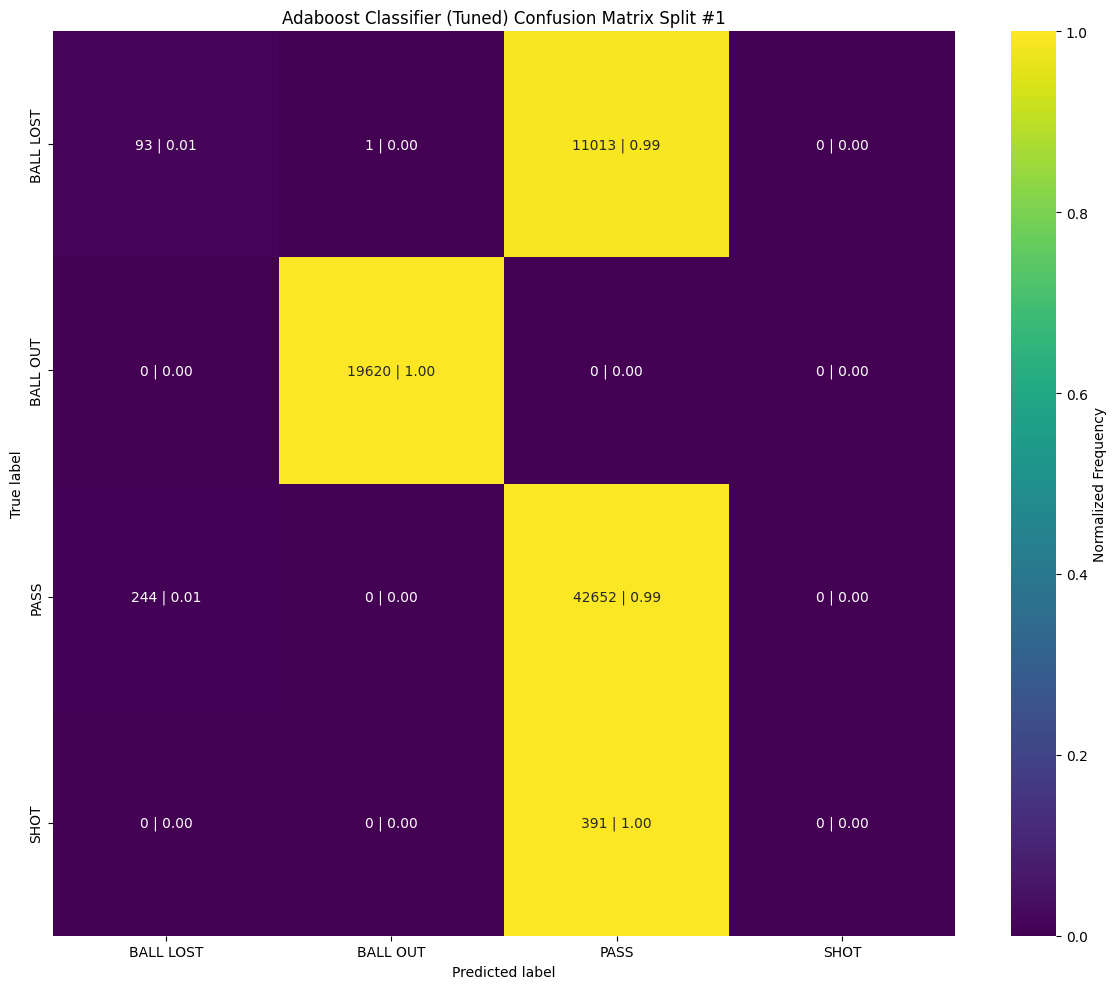

AdaBoost classifier (tuned) training accuracy: 83.20%
AdaBoost classifier (tuned) testing accuracy: 84.26%

AdaBoost classifier (tuned) testing precision: 76.38%
AdaBoost classifier (tuned) testing recall: 84.26%
AdaBoost classifier (tuned) testing f1: 77.75%



Performing Grid Search for Logistic regression...
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best parameters for Logistic regression: {'C': 0.01, 'max_iter': 500, 'penalty': 'l1', 'solver': 'saga'}


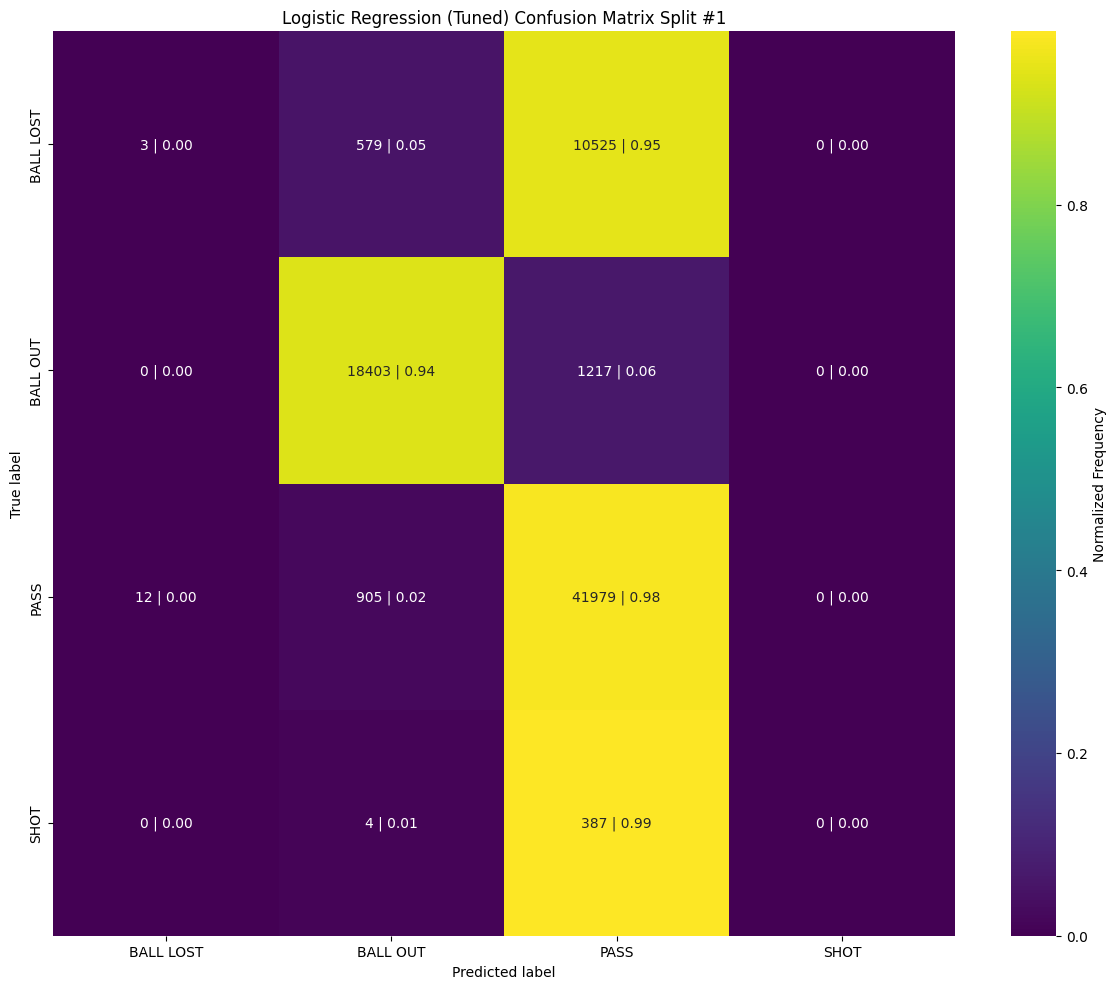

Logistic regression (tuned) training accuracy: 80.26%
Logistic regression (tuned) testing accuracy: 81.59%

Logistic regression (tuned) testing precision: 72.49%
Logistic regression (tuned) testing recall: 81.59%
Logistic regression (tuned) testing f1: 74.86%



Performing Grid Search for Random forest classifier...
Fitting 3 folds for each of 720 candidates, totalling 2160 fits
Best parameters for Random forest classifier: {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 50, 'n_jobs': -1}


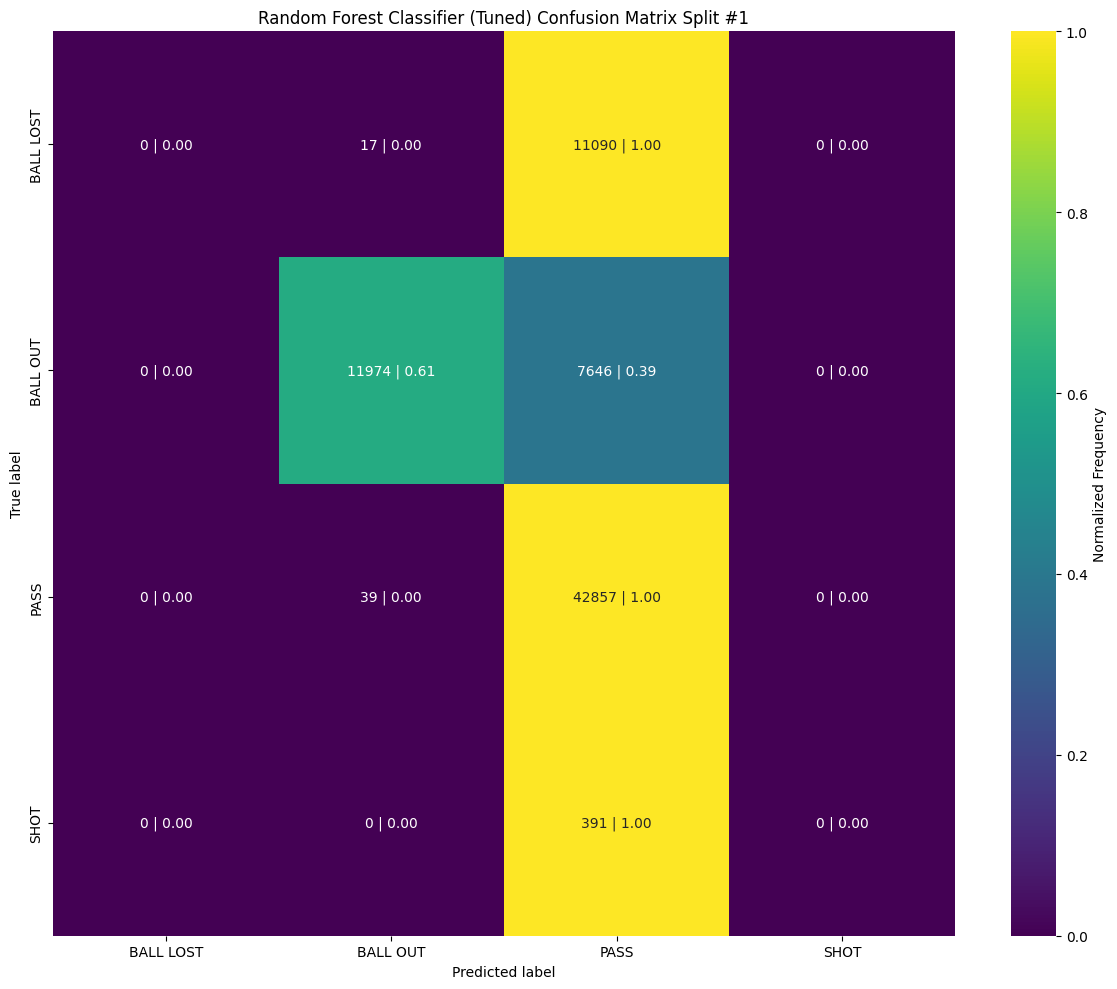

Random forest classifier (tuned) training accuracy: 81.03%
Random forest classifier (tuned) testing accuracy: 74.08%

Random forest classifier (tuned) testing precision: 66.46%
Random forest classifier (tuned) testing recall: 74.08%
Random forest classifier (tuned) testing f1: 67.42%




In [45]:
param_grids = {
    "AdaBoost classifier": {
        'n_estimators': [100, 150, 200, 250, 300],
        'learning_rate': [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
    },
    "Logistic regression": {
        'penalty': ['l1', 'l2'],
        'C': [0.0001, 0.001, 0.01, 0.1, 1],
        'solver': ['saga'],
        'max_iter': [500, 750, 1000, 1250]
    },
    "Random forest classifier": {
        'n_estimators': [20, 30, 40, 50, 60, 70],
        'max_depth': [4, 5, 6, 7, 8, 9],
        'min_samples_split': [3, 4, 5, 6, 7],
        "max_features": ["sqrt", "log2"],
        'n_jobs': [-1],  # Always use all cores
        "criterion": ["entropy", "gini"]
    }
}

# Dictionary to store best models
best_models = {}

for name, model in models.items():
    print(f"\nPerforming Grid Search for {name}...")

    grid_search = GridSearchCV(model, param_grids[name], cv=3, n_jobs=-1, verbose=4)
    grid_search.fit(X, y)
    
    best_model = grid_search.best_estimator_
    best_models[name] = best_model
    
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    
    # Predict and evaluate
    y_train_pred = best_model.predict(X)
    y_pred = best_model.predict(X_3_scaled)
    labels = np.unique(y)
    
    _ = plot_confusion_matrix(
        y_train=y,
        y_train_pred=y_train_pred,
        y_test=y_3,
        y_pred=y_pred,
        labels=labels,
        split=0,
        model_name=f"{name} (tuned)"
    )
